# Functional API

This notebook is based on [The Functional API](https://www.tensorflow.org/guide/keras/functional) Guide. 

## What is it?

The functional API is a way to build a _Graph of Layers_ as it is defined in the docs. So the smallest abstraction here is `Layer`, and you basically need an API to combine `Layer`s into arbitrary graphs (the [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) is just a short-cut for the simplest graph topology: a linear sequence of layers). 

## How it works?

Composing layers into arbitrary graphs is done by calling one model as a function with another (input one) as an argument (that's why it is called _"functional"_).

Here is a snippet from the base [Layer](https://github.com/keras-team/keras/blob/5986893dbaaa3c3ce1f07958ad5d3ec894ad20a9/keras/engine/base_layer.py#L1037-L1048) class `__call__` method: 

```python
# Functional Model construction mode is invoked when `Layer`s are called
# on symbolic `KerasTensor`s, i.e.:
# >> inputs = tf.keras.Input(10)
# >> outputs = MyLayer()(inputs)  # Functional construction mode.
# >> model = tf.keras.Model(inputs, outputs)
if _in_functional_construction_mode(
    self, inputs, args, kwargs, input_list
):
    return self._functional_construction_call(
        inputs, args, kwargs, input_list
    )

```

So the `_in_functional_construction_mode` is basically [checking](https://github.com/keras-team/keras/blob/5986893dbaaa3c3ce1f07958ad5d3ec894ad20a9/keras/engine/base_layer.py#L3639-L3646) the input arguments types:
```python
def _in_functional_construction_mode(layer, inputs, args, kwargs, input_list):
    """Check the arguments to see if we are constructing a functional model."""
    # We are constructing a functional model if any of the inputs
    # are KerasTensors
    return any(
        isinstance(tensor, keras_tensor.KerasTensor)
        for tensor in tf.nest.flatten([inputs, args, kwargs])
    )
```

If something that we pass is a _symbolic_ `KerasTensor`, then we're building the model, not invoking it on the read data. The Keras `Model` is just a [subclass](https://github.com/keras-team/keras/blob/5986893dbaaa3c3ce1f07958ad5d3ec894ad20a9/keras/engine/training.py#L67) of the `Layer`. To turn a model into `KerasTensor` you need to call with another `KerasTensor` as argument. `keras.layers.Input` is a subclass of `KerasTensor`. That's how the API is organized. 



## Simple Example

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations

inputs = layers.Input(shape=(28*28,), name="ImageInput-01")
l1 = layers.Dense(64, activation=activations.relu, name="Dense-01-01")
outputs = layers.Dense(10, activation=activations.relu, name="Outputs")

model = keras.Model(inputs=inputs, outputs=outputs(l1(inputs)), name="MLP_Model-01")

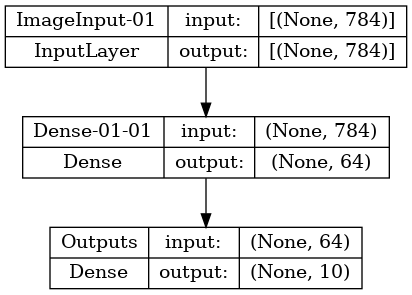

In [3]:
keras.utils.plot_model(model, show_shapes=True)

## Training, Evaluation and Inference

Because any `keras.Sequential` is an entity of the same kind as anything constructed by the functional API (a `Layer` in Keras' terms, even though it is rather an arbitrary graph of layers), the functional API provides exactly the same methods for training, evaluating and inference as the `keras.Sequential` model: `compile()`, `fit()`, `evaluate()`.

### Example: MNIST

#### Get Data

In [4]:
from dataclasses import dataclass, astuple
from typing import Any, Sequence

# Define a structure for nicer dataset access

@dataclass
class Dataset:
    """Dataset for supervised learning."""
    x: Sequence
    y: Sequence
        
@dataclass
class Split:
    """Split of dataset  for supervised learning."""
    train: Dataset
    test: Dataset
        
    @staticmethod
    def make(data) -> "Split":
        return Split(Dataset(*data[0]), Dataset(*data[1]))

# Load MNIS dataset 

mnist = Split.make(keras.datasets.mnist.load_data())

#### Prepare Data

In [5]:
mnist.train.x.shape

(60000, 28, 28)

In [6]:
mnist.test.x.shape

(10000, 28, 28)

In [7]:
mnist.train.x.max()

255

In [8]:
mnist.train.x = mnist.train.x.reshape(60000, 28*28) / 255
mnist.test.x = mnist.test.x.reshape(10000, 28*28) / 255
train, test = mnist.train, mnist.test

#### Train and Evaluate Model

In [9]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

epochs=10
history = model.fit(train.x, train.y, batch_size=64, epochs=epochs, validation_data=astuple(test))
test_scores = model.evaluate(test.x, test.y, verbose=2)

print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
938/938 [==============================] - 4s 3ms/step - loss: 0.9009 - accuracy: 0.6721 - val_loss: 0.6442 - val_accuracy: 0.7575
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.6184 - accuracy: 0.7613 - val_loss: 0.5985 - val_accuracy: 0.7690
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.5829 - accuracy: 0.7705 - val_loss: 0.5779 - val_accuracy: 0.7732
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5641 - accuracy: 0.7755 - val_loss: 0.5713 - val_accuracy: 0.7758
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.5516 - accuracy: 0.7775 - val_loss: 0.5637 - val_accuracy: 0.7760
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.5420 - accuracy: 0.7801 - val_loss: 0.5640 - val_accuracy: 0.7765
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.5343 - accuracy: 0.7818 - val_loss: 0.5619 - val_accuracy: 0.7766
Epoch 

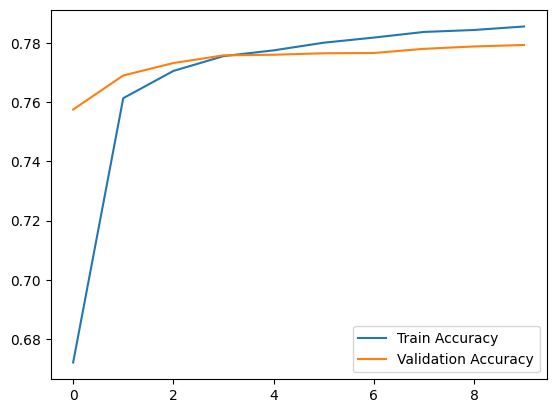

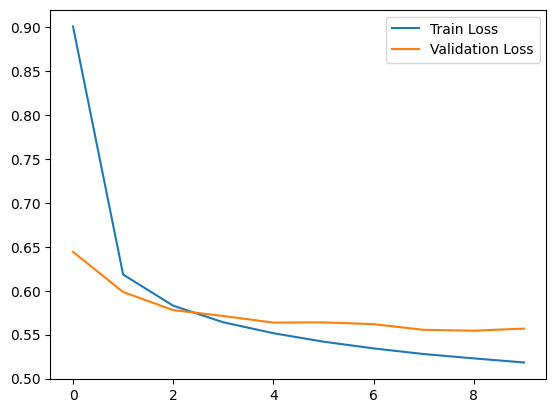

In [10]:
plt.plot(range(epochs), history.history['accuracy'], label="Train Accuracy")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(range(epochs), history.history['loss'], label="Train Loss")
plt.plot(range(epochs), history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

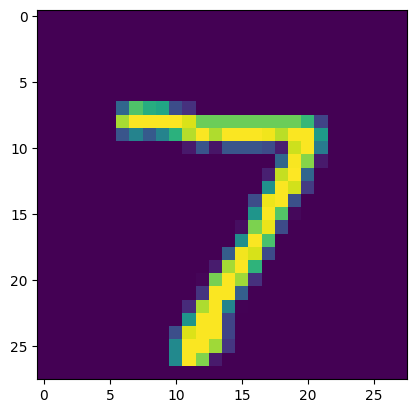

In [11]:
plt.imshow(test.x[0].reshape(28, 28))

In [12]:
def predict(model, value):
    return tf.argmax(model(tf.constant([value]))[0]).numpy()

predict(model, test.x[0])

0

#### Let's Build a Generator

In [13]:
def generate(model, digit, epochs=10000, learning_speed=0.001):
    init_value = tf.random.normal(shape=(1, 28*28)) * 10
    var =  tf.Variable(init_value)
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    losses = []

    for _ in range(epochs):
        with tf.GradientTape() as tape:
            loss_value = loss(y_true=digit, y_pred=model(var**2))
        grad = tape.gradient(loss_value, var)
        var.assign_sub(grad * learning_speed)
        losses.append(loss_value.numpy())
    
    return (var**2).numpy().reshape(28, 28), losses

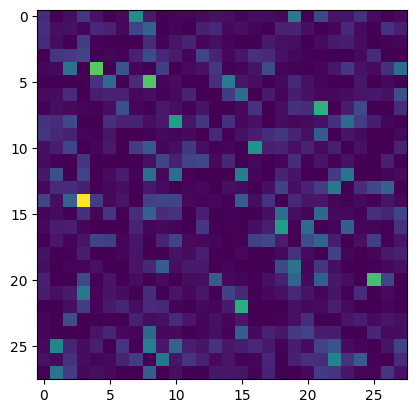

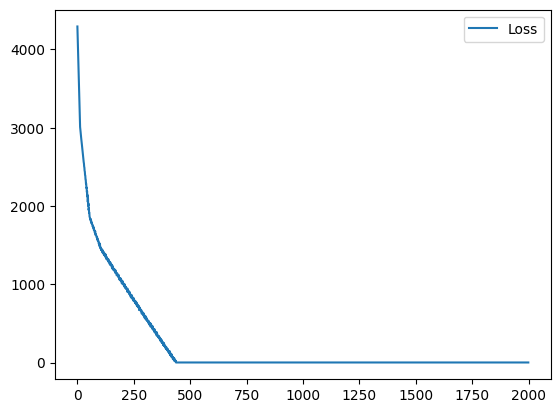

In [14]:
img, losses = generate(model, digit=8, epochs=2000, learning_speed=0.001)

plt.imshow(img)
plt.show()

plt.plot(range(len(losses)), losses, label="Loss")
plt.legend()
plt.show()

In [15]:
predict(model, img.reshape(28*28))

0

**Comment**: Hmm, strange... It seems like a small tweaking in the noise may convince the neural network the image is definitely '7'...

## Save and Serialize

This saved file includes the:

* model architecture
* model weight values (that were learned during training)
* model training config, if any (as passed to compile)
* optimizer and its state, if any (to restart training where you left off)

Loading model doesn't require original code to be available.

In [16]:
model.save("output/01_func_api_mnist_model")

INFO:tensorflow:Assets written to: output/01_func_api_mnist_model/assets


INFO:tensorflow:Assets written to: output/01_func_api_mnist_model/assets


In [17]:
loaded_model = keras.models.load_model("output/01_func_api_mnist_model")
predict(loaded_model, test.x[0])

0

In [18]:
x = tf.random.uniform(shape=(2,2), minval=-1, maxval=1)
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.7595794 ,  0.11506224],
       [-0.7770097 , -0.66002035]], dtype=float32)>

In [19]:
tf.reduce_sum(tf.math.abs(tf.math.minimum(0, x))**2)

<tf.Tensor: shape=(), dtype=float32, numpy=1.039371>

## Reuse the Same Graph to Define Multiple Models?

Functional API allows to construct an arbitrary graphs of layers. `Model` is a graph of layers in which some nodes are designated as `inputs` and `outputs`. 

Below the same sub-graph is used to define `encoder` model and full e2e `autoencoder` model.

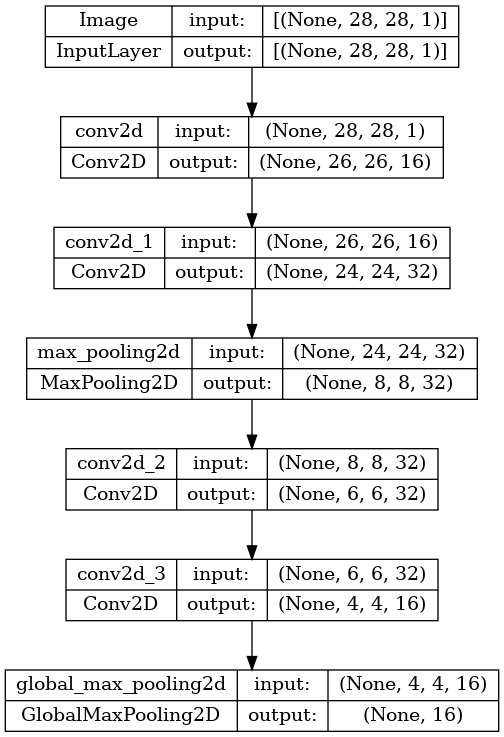

In [20]:
encoder_input = keras.Input(shape=(28, 28, 1), name="Image")
x = layers.Conv2D(16, 3, activation=activations.relu)(encoder_input)
x = layers.Conv2D(32, 3, activation=activations.relu)(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation=activations.relu)(x)
x = layers.Conv2D(16, 3, activation=activations.relu)(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(inputs=encoder_input, outputs=encoder_output, name="Encoder")
keras.utils.plot_model(encoder, show_shapes=True)

### Decoder

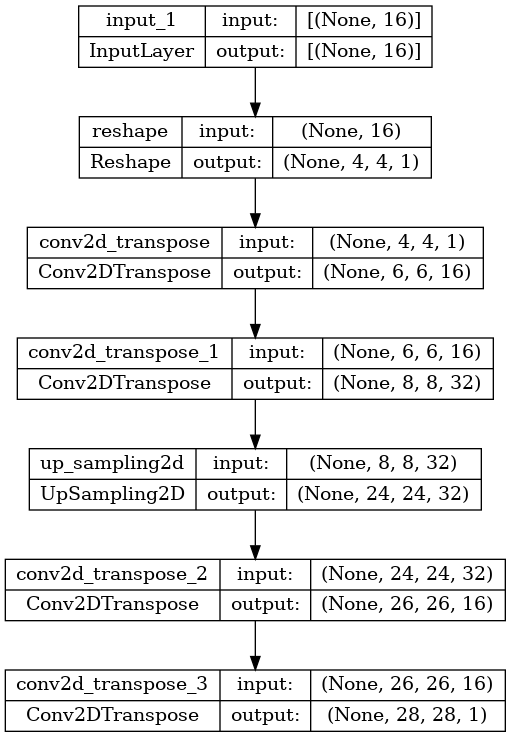

In [21]:
#decoder_input = layers.Input(shape=(16,), name="encoded")
decoder_first = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation=activations.relu)(decoder_first)
x = layers.Conv2DTranspose(32, 3, activation=activations.relu)(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation=activations.relu)(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation=activations.relu)(x)

decoder = keras.Model(inputs=encoder_output, outputs=decoder_output, name="Decoder")
keras.utils.plot_model(decoder, show_shapes=True)

### Autoencoder

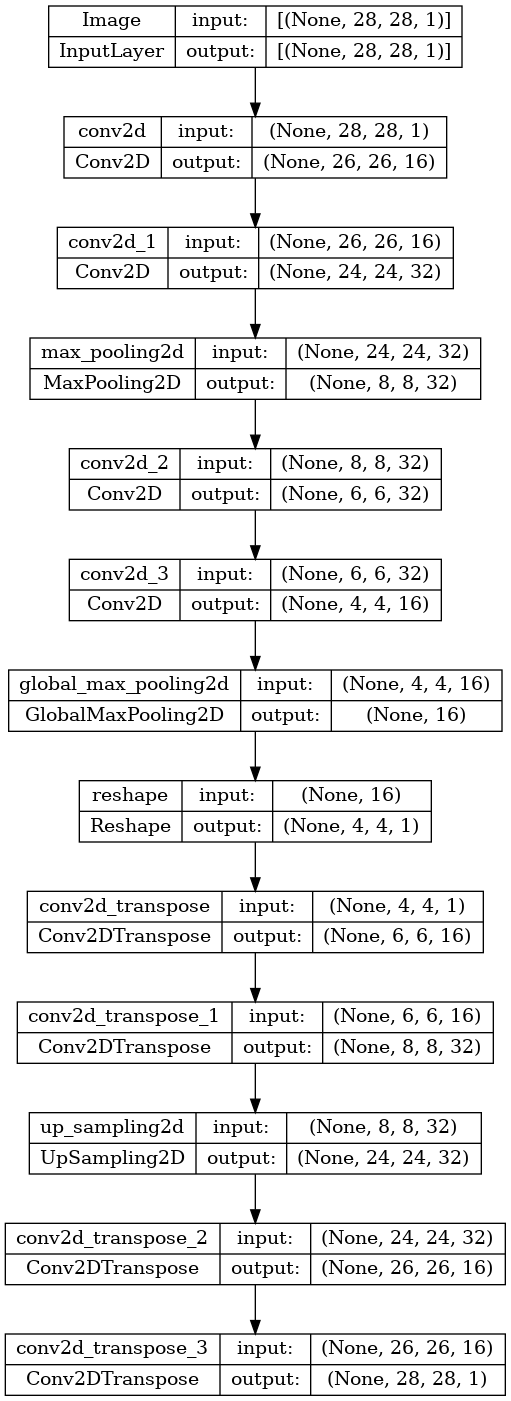

In [22]:
autoencoder = keras.Model(inputs=encoder_input, outputs=decoder_output, name="Autoencoder")
keras.utils.plot_model(autoencoder, show_shapes=True)

Let's try to train this. :)

#### Prepare MNIST Data

In [23]:
mnist = Split.make(keras.datasets.mnist.load_data())
mnist.train.x = mnist.train.x.reshape(60000, 28, 28, 1) / 255
mnist.test.x = mnist.test.x.reshape(10000, 28, 28, 1) / 255
train, test = mnist.train, mnist.test

#### Train the Model

In [24]:
autoencoder.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

epochs=10
history = autoencoder.fit(
    train.x, 
    train.x, 
    epochs=epochs, 
    validation_data=(test.x, test.x)
)
test_scores = autoencoder.evaluate(test.x, test.x, verbose=2)

print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 0.0382 - accuracy: 0.8029 - val_loss: 0.0292 - val_accuracy: 0.8041
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0280 - accuracy: 0.8062 - val_loss: 0.0260 - val_accuracy: 0.8050
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0257 - accuracy: 0.8071 - val_loss: 0.0244 - val_accuracy: 0.8064
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0244 - accuracy: 0.8077 - val_loss: 0.0232 - val_accuracy: 0.8065
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0234 - accuracy: 0.8081 - val_loss: 0.0222 - val_accuracy: 0.8073
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0226 - accuracy: 0.8084 - val_loss: 0.0218 - val_accuracy: 0.8081
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0221 - accuracy: 0.8087 - val_loss: 0.0213 - val_ac

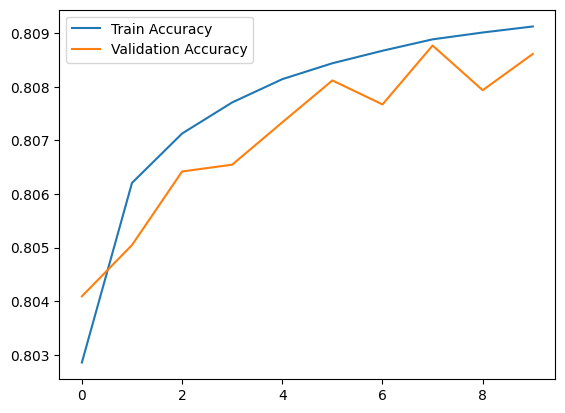

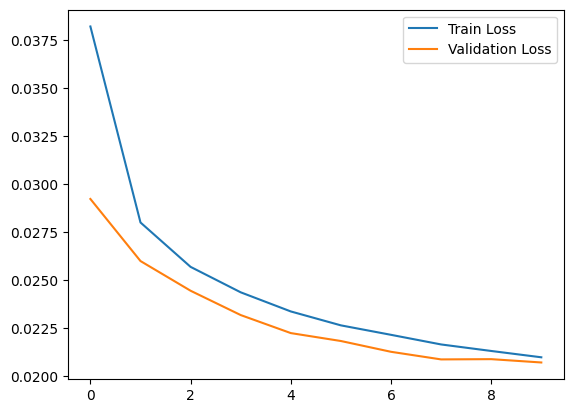

In [25]:
plt.plot(range(epochs), history.history['accuracy'], label="Train Accuracy")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(range(epochs), history.history['loss'], label="Train Loss")
plt.plot(range(epochs), history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

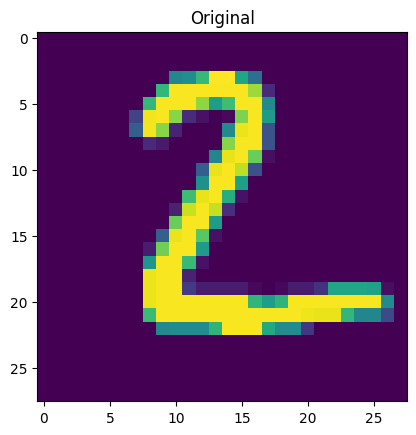

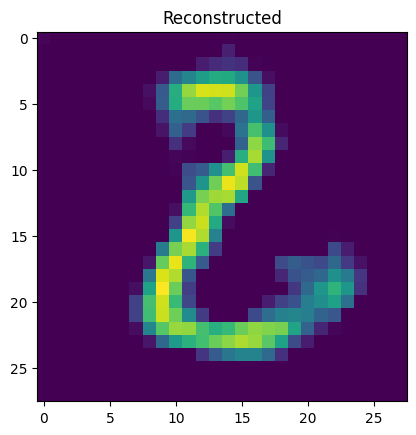

In [26]:
plt.imshow(test.x[1])
plt.title("Original")
plt.show()

plt.imshow(autoencoder(tf.constant(test.x[1:2]))[0])
plt.title("Reconstructed")
plt.show()

Hurrray!!!! We reconstructed the input with decent precision!!!

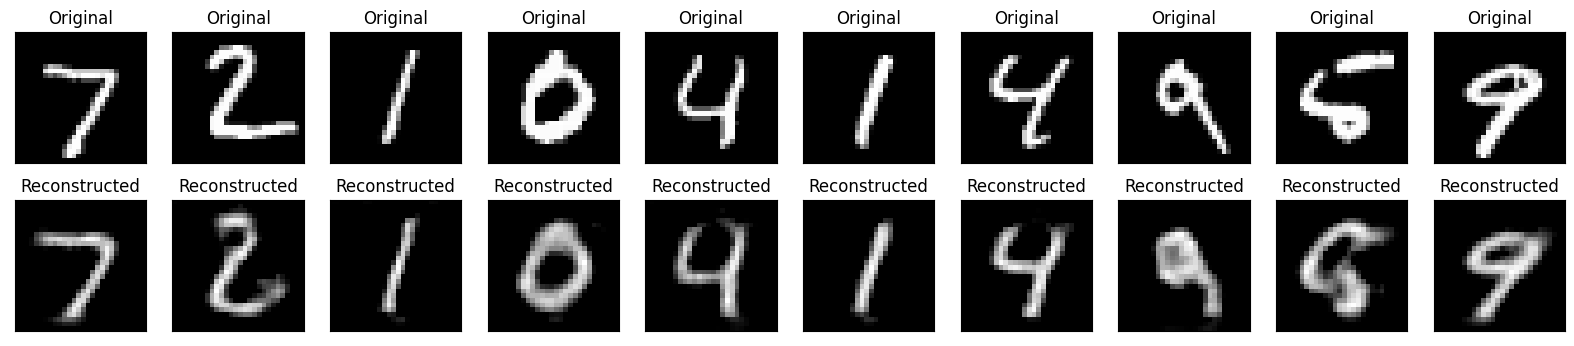

In [27]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test.x[i])
  plt.title("Original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(autoencoder(tf.constant(test.x[i:i+1]))[0])
  plt.title("Reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Let's Visualize Autoencoder Just For FUN!!!

In [28]:
max_vals = tf.math.reduce_max(encoder.predict(train.x), axis=0)
min_vals = tf.math.reduce_min(encoder.predict(train.x), axis=0)

1875/1875 [==============================] - 3s 1ms/step


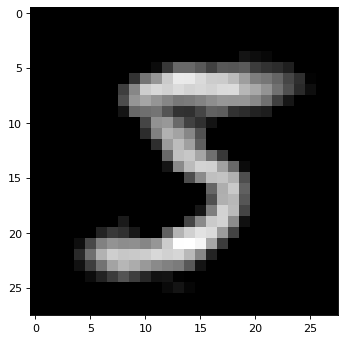

In [30]:
import numpy as np
import ipywidgets as widgets
from ipywidgets import Output
from IPython.display import display, clear_output
from functools import partial


class AutoEncoderUI:
    def __init__(self, min_vals, max_vals, decoder:keras.Model, initial):
        if len(min_vals) != len(max_vals):
            raise ValueError(f"Unequal min_vals and max_vals lenght: {len(min_vals)} != {len(max_vals)}")
        if len(min_vals) != len(initial):
            raise ValueError(f"Invalid initial value shape")
        self.min_vals = min_vals
        self.max_vals = max_vals
        self.dims:int = len(min_vals)
        self.model:keras.Model = model
        self.value = np.array(initial)
        
        self.sliders = []
        for i in range(self.dims):
            slider = widgets.FloatSlider(min=self.min_vals[i], max=self.max_vals[i], description=f"Component #{i}", value=initial[i], step=(self.max_vals[i] - self.min_vals[i])/1000)
            slider.observe(partial(self.on_change, i), names='value')
            self.sliders.append(slider)
            
        self.figure = plt.figure(figsize=(5, 5), dpi=80)
        self.axes = self.figure.gca()
        self.axes.set_aspect('equal', adjustable='box')
        
        self.decoder = decoder
        self.output=widgets.VBox(children=list(self.sliders))
            
            
    def on_change(self, i, change):
        self.value[i] = change['new']
        self.display()
        
    def display(self):
        output = Output()
        with output:
            img = self.decoder(tf.constant([self.value]))
            self.axes.clear()
            self.axes.imshow(img[0])
            display(self.figure)
            
        self.output.children = self.sliders + [output]
        

initial = encoder(train.x[:1])[0]
ui = AutoEncoderUI(min_vals, max_vals, decoder, initial)
ui.display()
display(ui.output)

# Manipulate Complex Graphs

## Models with Multiple Inputs and Outputs

The functional API allows to build models with multiple inputs and outputs

### Example

Let's say we want to build an intelligent issue tracker that will (1) rank issues and (2) route them to the correct department. 

The model will have 3 inputs:
* ticket title (text input)
* text body of the ticket (text input)
* and tags added by the user (categorical input)

This model will have two outputs:
* the priority of the ticket between 0 and 1 (scalar sigmoid output)
* the department that should handle the ticket (softmax output over the set of departements)

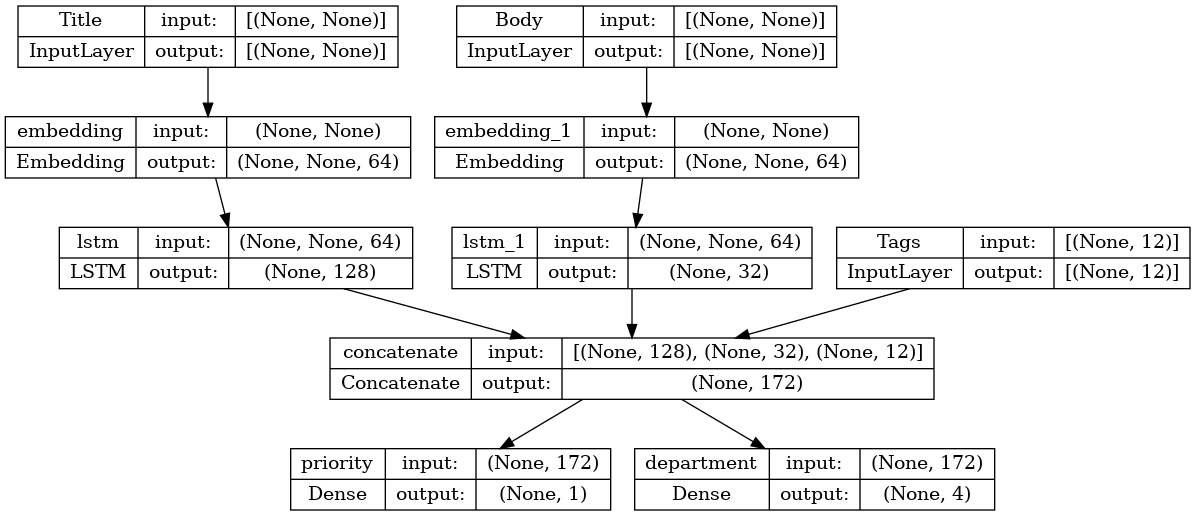

In [31]:
num_tags = 12
num_words = 10000 # Size of vocabulary
num_departments = 4


title_input = keras.Input(shape=(None,), name="Title") # Seq of ints
body_input = keras.Input(shape=(None,), name="Body") # Seq of ints
tags_input = keras.Input(shape=(num_tags,), name="Tags") # Binary vectors

title_features = layers.Embedding(num_words, 64)(title_input)
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embeddings into a single 128-dim and 32-dim vectors
title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(32)(body_features)

# Merge vectors by concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Predict priority
priority_pred = layers.Dense(1, name="priority")(x)

# Predict department
department_pred = layers.Dense(num_departments, name="department")(x)


# Build model:
ticket_model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred]
)

keras.utils.plot_model(ticket_model, show_shapes=True)

It is possible to use different losses for different outputs, and different loss weights for each:

In [32]:
ticket_model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

It is possible to assign losses and weight by outputs names:

In [33]:
ticket_model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

Let's train the model on fake data:

In [34]:
import numpy as np

# Dummy input data
sample_size = 2000
title_data = np.random.randint(num_words, size=(sample_size, 10))
body_data = np.random.randint(num_words, size=(sample_size, 100))
tags_data = np.random.randint(2, size=(sample_size, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(sample_size, 1))
dept_targets = np.random.randint(2, size=(sample_size, num_departments))

Train the model:

In [35]:
ticket_model.fit(
    x={"Title": title_data, "Body": body_data, "Tags": tags_data},
    y={"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
63/63 [==============================] - 2s 15ms/step - loss: 1.3058 - priority_loss: 0.7008 - department_loss: 3.0254
Epoch 2/2
63/63 [==============================] - 1s 17ms/step - loss: 1.2932 - priority_loss: 0.6991 - department_loss: 2.9704


## Toy ResNet Model

Here is an example of non-linear topology - a [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) network (see [Kaiming He et. al., Deep Residual Learning for Image Recognition, 2016](https://sci-hub.ru/10.1109/CVPR.2016.90))

![ResNet](./docs/res-net.png)

### Intuitions on ResNet

1. Apart of deep NN we have a short-cut high-way for more important information
2. On each ResNet building block we take a raw input and _augment_ it with some additional _illusory_ information, which was also derived from the raw input. This is similar to how we humans may experience different illusions that modify the input perception to fit to our expectations. 
3. Kaiming He were working on the problem of training accuracy degradation which manifests with the increase of the number of layers in the NN. The problem cannot be explained by the overfit, because NN performs poorly on the training set. The problem is caused by the optimization problem getting more difficult with the increase of layers number. But there is always a simple solution for deeper NN to perform at least as good as more shallow counter parts: just turn additional layers into identity mappings. But, He hypothesised, it might be difficult to turn a stack of multiple non-linear layers into an identity. To make it simpler, He proposed to shortcut groups of layers, sot the reduction-to-shallow-counterpart will become more computationally simple: just make the short-cutted layers zeros and that's it. There is no evidence that it is this explaination that correctly explicate the `ResNet` results. But `ResNets` enjoys ever increasing accuracy with the increase of N of layers. 

Here is also an important quote from the He's paper about addressing **vanishing/exploding gradients problem**: 
> Driven by the significance of depth, a question arises: Is learning better networks as easy as stacking more layers? An obstacle to answering this question was the notorious problem of vanishing/exploding gradients [14, 1, 8], which hamper convergence from the beginning. **This problem, however, has been largely addressed by normalized initialization [23, 8, 36, 12] and intermediate normalization layers [16], which enable networks with tens of layers to start converging for stochastic gradient descent (SGD) with backpropagation [22]**.

### Building the Toy ResNet

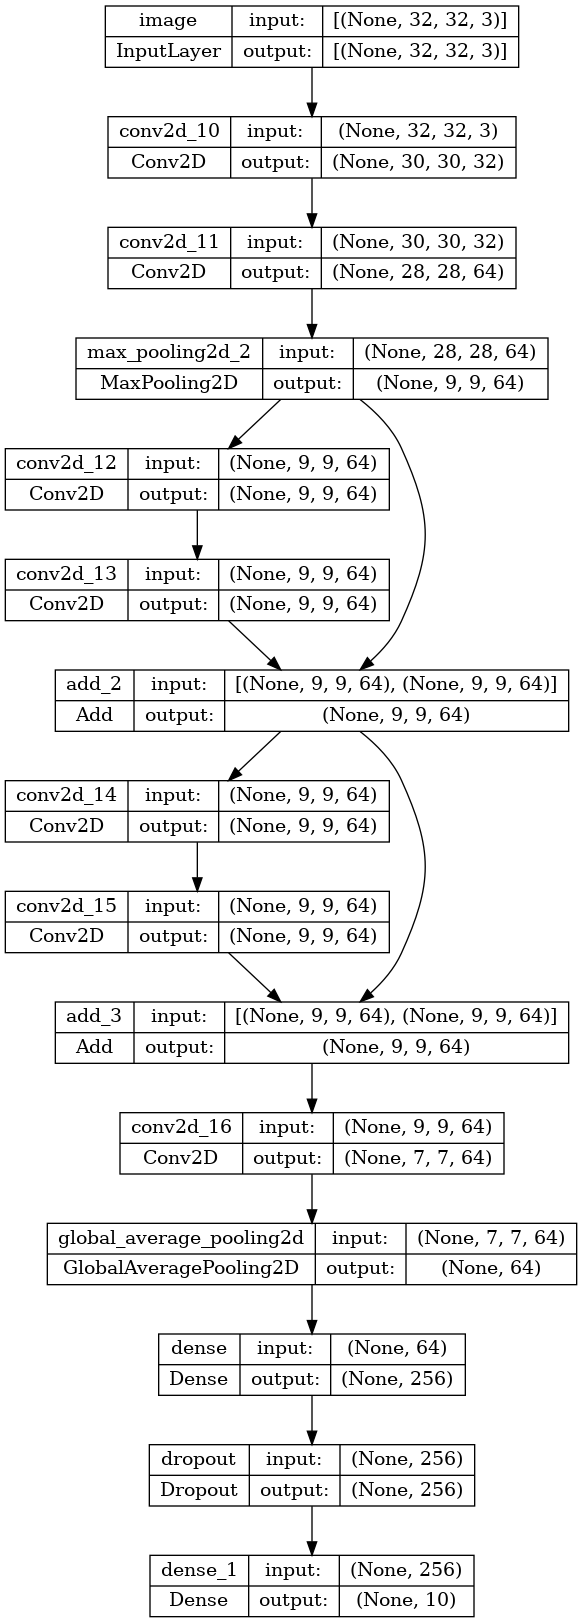

In [37]:
inputs = layers.Input(shape=(32, 32, 3), name="image")
x = layers.Conv2D(32, 3, activation=activations.relu)(inputs)
x = layers.Conv2D(64, 3, activation=activations.relu)(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation=activations.relu, padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation=activations.relu, padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation=activations.relu, padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation=activations.relu, padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation=activations.relu)(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation=activations.relu)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

resnet_model=keras.Model(inputs=inputs, outputs=outputs, name="toy_resnet")
keras.utils.plot_model(resnet_model, show_shapes=True)

Now let's train this monster XD

In [ ]:
cifar10 = Split.make(keras.datasets.cifar10.load_data())
cifar10.train.x = cifar10.train.x.astype('float32') / 255.0
cifar10.test.x = cifar10.test.x.astype('float32') / 255.0
cifar10.train.y = keras.utils.to_categorical(cifar10.train.y, 10)
cifar10.test.y = keras.utils.to_categorical(cifar10.test.y, 10)

 26140672/170498071 [===>..........................] - ETA: 27:53

In [ ]:
resnet_model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)

resnet_model.fit(cifar10.test.x[:1000], cifar10.train.y[:1000], batch_size=64, epochs=1, validation_split=0.2)